# API functions

In [2]:
import pandas as pd
import numpy as np
import os
import pyteomics.mzml
import spectrum_utils.spectrum as sus
from pathlib import Path

In [3]:
# Note: When inputting the file paths, please do them sequentially to facilitate matching
# mzml and peptide files.
mzml_file_names = []
peptide_file_names = []
protein_file_names = []

mzml_file_paths = ["C:\\Users\\Sarah Curtis\\OneDrive - BYU\\Documents\\Single Cell Team Documents\\API_dev\\Ex_Auto_J3_30umTB_2ngQC_60m_1.mzML"]
peptide_file_paths = ["C:\\Users\\Sarah Curtis\\OneDrive - BYU\\Documents\\Single Cell Team Documents\\API_dev\\Ex_Auto_J3_30umTB_2ngQC_60m_1-calib_Peptides.psmtsv"]
protein_file_paths = ["C:\\Users\\Sarah Curtis\\OneDrive - BYU\\Documents\\Single Cell Team Documents\\API_dev\\Ex_Auto_J3_30umTB_2ngQC_60m_1-calib_ProteinGroups.tsv"]

In [4]:
def create_scan_file_paths_dict(file_paths, peptide_dataframe_dict):
    scan_file_paths_dict = {}
    protein_to_scan_dict = {}
    for file_index, peptide_file in enumerate(file_paths):
        peptide_dataframe = peptide_dataframe_dict[file_paths[file_index]]
        for index, row in peptide_dataframe.iterrows():
            scan = str(row['Scan Number'])
            protein = str(row['Protein Accession'])
            scan_file_paths_dict[scan] = [mzml_file_paths[file_index], peptide_file, protein]
            if protein in protein_to_scan_dict.keys():
                #print(f"Adding additional scan for {protein}")
                if protein_to_scan_dict[protein] == None:
                    print(protein_to_scan_dict)
                #print(protein_to_scan_dict[protein])
                protein_to_scan_dict[protein].append(scan)
                #print(protein_to_scan_dict[protein])
            elif scan != None:
                protein_to_scan_dict[protein] = [scan]
                #protein_to_scan_dict[protein] = protein_to_scan_dict[protein].append(scan)
    return scan_file_paths_dict, protein_to_scan_dict

def load_peptide_data(file_paths):
    dataframe_dict = {}
    for file_path in file_paths:
        dataframe_dict[file_path] = pd.read_table(file_path, delimiter='\t')
        dataframe_dict[file_path] = dataframe_dict[file_path].sort_values("QValue")
        dataframe_dict[file_path] = dataframe_dict[file_path].drop_duplicates(subset=["Scan Number"], keep="first")
    scan_to_file_paths_dict, protein_to_scan_dict = create_scan_file_paths_dict(file_paths, dataframe_dict)
    return dataframe_dict, scan_to_file_paths_dict, protein_to_scan_dict

def load_protein_data(file_paths):
    dataframe_dict = {}
    for file_path in file_paths:
        dataframe_dict[file_path] = pd.read_table(file_path, delimiter='\t')
    return dataframe_dict

def printDictionary(myDict):
    for key in myDict.keys():
        print(f"{key}: {myDict[key]}")

# create the peptide and protein dataframe dictionaires
peptide_dataframe_dict, scan_to_file_paths_dict, protein_to_scan_dict = load_peptide_data(peptide_file_paths)
protein_dataframe_dict = load_protein_data(protein_file_paths)

In [5]:
# This function would probably take too long
def load_mzml_data(mzml_file_path, peptide_file_paths):
    dict_of_spectrum_dict = {}
    # here we will be assuming that the peptide file paths list is aligned with
    # the mzml path list
    for index, mzml_file_path in enumerate(mzml_file_paths):
        peptide_dataframe = peptide_dataframe_dict[peptide_file_paths[index]]
        for index, row in peptide_dataframe.iterrows():
            scan = row['Scan Number']
            print(f"Processing scan number {scan}.")
            dict_of_spectrum_dict[scan] = get_mzml_ms2_scan_data(scan=scan, mzML_file_path=mzml_file_path) 
    return dict_of_spectrum_dict

def get_mzml_ms2_scan_data(scan, mzML_file_path):
    if scan in dict_of_scan_data.keys():
        print(f"{scan}'s data was already in the scan data dictionary")
        return dict_of_scan_data[scan]

    # create the mzml object
    mzml = pyteomics.mzml.MzML(mzML_file_path)
    my_id = 'controllerType=0 controllerNumber=1 scan='+ str(scan)
    spectrum_dict = mzml.get_by_id(my_id)
    dict_of_scan_data[scan] = spectrum_dict

    return spectrum_dict

In [6]:
dict_of_scan_data = {}
dict_of_scan_data['16668'] = get_mzml_ms2_scan_data('16668', mzml_file_paths[0])

<AxesSubplot:xlabel='m/z', ylabel='intensity'>

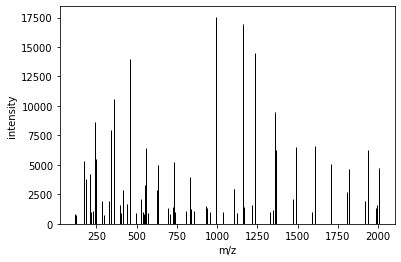

In [7]:
# hmm..I think it would take too long to collect all of the data for all of the spectra
# instead, maybe when you want to look at a particular scan, then we can call up the 
# spectra_dictionary and store that in the dictionary of all of them so we don't have to 
# repeat our work

# this means that part of calling up information about something involves checking if 
# we already have the data in the dictionary and if not, creating the dictionary for it

# obtain data on one spectrum (do we need to know which mzml file contain that scan?)
# match the peptide with the scan

import pyteomics.pylab_aux
pyteomics.pylab_aux.plot_spectrum(dict_of_scan_data['16668'])

In [8]:
def pull_out_relevant_info(spectrum_dict):
    spectrum_id = spectrum_dict['id']
    retention_time = (spectrum_dict['scanList']['scan'][0].get('scan start time', -1))
    mz_array = list(spectrum_dict['m/z array'])
    intensity_array = list(spectrum_dict['intensity array'])

    if 'precursorList' in spectrum_dict.keys():
        precursor = spectrum_dict['precursorList']['precursor'][0]
        precursor_ion = precursor['selectedIonList']['selectedIon'][0]
        precursor_mz = precursor_ion['selected ion m/z']
        if 'peak intensity' in precursor_ion:
            precursor_intensity =  precursor_ion['peak intensity']
        else:
            precursor_intensity = None
        if 'charge state' in precursor_ion:
            precursor_charge = int(precursor_ion['charge state'])
        elif 'possible charge state' in precursor_ion:
            precursor_charge = int(precursor_ion['possible charge state'])
        else:
            precursor_charge = 'NAN'
    else:
        precursor_intensity = None
        
    all_info = [mz_array,intensity_array,precursor_intensity]

    return all_info

def generate_protein_scan_dataframe(protein):
    mz_array_data = []
    intensity_array = []
    precursor_intensity = []

    # loop through the scans associated with the protein
    for count, scan in enumerate(protein_to_scan_dict[protein]):
        scan_spectrum_dict = {}
        mzml_file = scan_to_file_paths_dict[scan][0]
        peptide_file = scan_to_file_paths_dict[scan][1]

        # if the scans already have their spectrum dictionary stored, use that
        if scan in dict_of_scan_data.keys():
            scan_spectrum_dict = dict_of_scan_data[scan]

        # if not, create the spectrum dictionary
        else:
            scan_spectrum_dict = get_mzml_ms2_scan_data(scan, mzml_file)
        
        # store the relevant information in their respective lists so they can be added
        # as columns later
        relevant_info = pull_out_relevant_info(scan_spectrum_dict)
        mz_array_data.append(relevant_info[0])
        intensity_array.append(relevant_info[1])
        precursor_intensity.append(relevant_info[2])

        peptide_dataframe = peptide_dataframe_dict[peptide_file]
        # for the first time through the loop, create a new dataframe with one row
        if count == 0:
            new_dataframe = peptide_dataframe[peptide_dataframe["Scan Number"] == int(scan)]

        # for the other times through, add a new row to the dataframe
        else:
            new_dataframe = new_dataframe.append(peptide_dataframe[peptide_dataframe["Scan Number"] == int(scan)], ignore_index = True)
    
    # add the mz_array, intensity_array, and precursor_intensity to the dataframe
    headers_to_add = ['mz_array_data', 'intensity_array', 'precursor_intensity']
    columns_to_add = [mz_array_data, intensity_array, precursor_intensity]  
    for index, column in enumerate(columns_to_add):
        header = headers_to_add[index]
        new_dataframe[header] = column
    
    return new_dataframe

# Oh, we might also want to have some functions that can save the generated dataframes as tsv files
# if we want to be able to access them later.


In [9]:
P10809_dataframe = generate_protein_scan_dataframe('P10809')
P10809_dataframe

C:\Users\Sarah Curtis\AppData\Local\Temp\ipykernel_24208\2994936224.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(peptide_dataframe[peptide_dataframe["Scan Number"] == int(scan)], ignore_index = True)


,File Name,Scan Number,Scan Retention Time,Num Experimental Peaks,Total Ion Current,Precursor Scan Number,Precursor Charge,Precursor MZ,Precursor Mass,Score,...,Cumulative Decoy,QValue,Cumulative Target Notch,Cumulative Decoy Notch,QValue Notch,PEP,PEP_QValue,mz_array_data,intensity_array,precursor_intensity
0,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,16668,52.52059,101.0,3.352519e+05,16649,2.0,1280.62784,2559.24113,28.510,...,0,0.000000,1,0,0.000000,0.000063,0.000026,"[118.0188980102539, 124.82211303710938, 175.11...","[813.1907348632812, 718.8142700195312, 5288.52...",1.068945e+05
1,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,28216,80.17758,35.0,6.137224e+04,28202,2.0,801.37943,1600.74430,12.451,...,0,0.000000,1707,0,0.000000,0.000015,0.000008,"[120.08116912841797, 133.04339599609375, 169.0...","[1769.400390625, 2426.509765625, 1022.70935058...",6.520644e+04
2,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,17585,54.71099,109.0,3.435274e+05,17573,2.0,456.79714,911.57973,13.268,...,0,0.000000,1374,0,0.000000,0.001810,0.000293,"[110.07178497314453, 120.08119201660156, 129.0...","[3424.820556640625, 3355.81005859375, 1092.459...",1.477345e+05
3,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,7584,30.91594,192.0,7.730841e+05,7572,2.0,617.30150,1232.58846,16.406,...,0,0.000000,318,0,0.000000,0.000043,0.000020,"[110.07171630859375, 113.07138061523438, 115.0...","[2885.594970703125, 4330.07275390625, 1327.898...",5.256449e+05
4,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,27606,78.71106,50.0,1.099450e+05,27586,2.0,842.95621,1683.89786,16.561,...,0,0.000000,259,0,0.000000,0.000080,0.000032,"[143.0821075439453, 175.1194610595703, 197.129...","[1055.2406005859375, 2106.62353515625, 1185.54...",2.251607e+04
5,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,13382,44.68455,59.0,8.831165e+05,13370,2.0,616.32295,1230.63134,16.261,...,0,0.000000,363,0,0.000000,0.000001,0.000000,"[110.07154083251953, 112.0872802734375, 113.07...","[4301.97412109375, 3231.796142578125, 1461.705...",4.067937e+05
6,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,25212,72.95852,93.0,2.764365e+05,25199,2.0,1021.02885,2040.04315,21.442,...,0,0.000000,26,0,0.000000,0.000043,0.000020,"[114.56816101074219, 130.08636474609375, 142.6...","[826.9525146484375, 739.6585083007812, 795.503...",1.063309e+05
7,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,27928,79.48682,56.0,1.426934e+05,27916,2.0,1019.51593,2037.01730,19.609,...,0,0.000000,52,0,0.000000,0.000150,0.000055,"[112.07440948486328, 131.11827087402344, 136.0...","[752.7034301757812, 3032.86962890625, 892.4647...",8.250762e+04
8,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,22471,66.38304,92.0,2.268966e+05,22459,2.0,886.42920,1770.84385,14.298,...,0,0.000000,885,0,0.000000,0.000021,0.000010,"[110.73738098144531, 119.575439453125, 127.620...","[695.9367065429688, 672.0747680664062, 646.185...",7.230391e+04
9,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,30510,85.72137,72.0,2.199676e+05,30498,3.0,640.36290,1918.06688,14.297,...,0,0.000000,886,0,0.000000,0.000007,0.000003,"[141.10272216796875, 155.11856079101562, 169.0...","[2200.91943359375, 952.1298828125, 4761.242675...",8.916583e+04


In [10]:
# Oh, we might also want to have some functions that can save the generated dataframes as tsv files
# if we want to be able to access them later.

# Things we might want to save:
#    - The dataframes we create
#    - The spectrum-dictionary if you don't want to have to run it again
#    - 

In [11]:
def save_dataframe_as_tsv(dataframe, file_name, file_path=None):
    if file_path != None:
        dataframe.to_csv(file_path, sep="\t", index=False)
    else:
        file_path = "C:\\Users\\Sarah Curtis\\OneDrive - BYU\\Documents\\Single Cell Team Documents\\API_dev\\" + file_name + '.tsv'
        dataframe.to_csv(file_path, sep="\t", index=False)
    print(f'Dataframe saved.')

In [12]:
save_dataframe_as_tsv(P10809_dataframe, 'P10809_dataframe')

Dataframe saved.


In [13]:
myPath = "C:\\Users\\Sarah Curtis\\OneDrive - BYU\\Documents\\Single Cell Team Documents\\API_dev\\P10809_dataframe.tsv"
P10809_dataframe = pd.read_table(myPath, delimiter='\t')
P10809_dataframe

,File Name,Scan Number,Scan Retention Time,Num Experimental Peaks,Total Ion Current,Precursor Scan Number,Precursor Charge,Precursor MZ,Precursor Mass,Score,...,Cumulative Decoy,QValue,Cumulative Target Notch,Cumulative Decoy Notch,QValue Notch,PEP,PEP_QValue,mz_array_data,intensity_array,precursor_intensity
0,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,16668,52.52059,101.0,3.352519e+05,16649,2.0,1280.62784,2559.24113,28.510,...,0,0.000000,1,0,0.000000,0.000063,0.000026,"[118.0188980102539, 124.82211303710938, 175.11...","[813.1907348632812, 718.8142700195312, 5288.52...",1.068945e+05
1,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,28216,80.17758,35.0,6.137224e+04,28202,2.0,801.37943,1600.74430,12.451,...,0,0.000000,1707,0,0.000000,0.000015,0.000008,"[120.08116912841797, 133.04339599609375, 169.0...","[1769.400390625, 2426.509765625, 1022.70935058...",6.520644e+04
2,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,17585,54.71099,109.0,3.435274e+05,17573,2.0,456.79714,911.57973,13.268,...,0,0.000000,1374,0,0.000000,0.001810,0.000293,"[110.07178497314453, 120.08119201660156, 129.0...","[3424.820556640625, 3355.81005859375, 1092.459...",1.477345e+05
3,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,7584,30.91594,192.0,7.730841e+05,7572,2.0,617.30150,1232.58846,16.406,...,0,0.000000,318,0,0.000000,0.000043,0.000020,"[110.07171630859375, 113.07138061523438, 115.0...","[2885.594970703125, 4330.07275390625, 1327.898...",5.256449e+05
4,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,27606,78.71106,50.0,1.099450e+05,27586,2.0,842.95621,1683.89786,16.561,...,0,0.000000,259,0,0.000000,0.000080,0.000032,"[143.0821075439453, 175.1194610595703, 197.129...","[1055.2406005859375, 2106.62353515625, 1185.54...",2.251607e+04
5,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,13382,44.68455,59.0,8.831165e+05,13370,2.0,616.32295,1230.63134,16.261,...,0,0.000000,363,0,0.000000,0.000001,0.000000,"[110.07154083251953, 112.0872802734375, 113.07...","[4301.97412109375, 3231.796142578125, 1461.705...",4.067937e+05
6,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,25212,72.95852,93.0,2.764365e+05,25199,2.0,1021.02885,2040.04315,21.442,...,0,0.000000,26,0,0.000000,0.000043,0.000020,"[114.56816101074219, 130.08636474609375, 142.6...","[826.9525146484375, 739.6585083007812, 795.503...",1.063309e+05
7,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,27928,79.48682,56.0,1.426934e+05,27916,2.0,1019.51593,2037.01730,19.609,...,0,0.000000,52,0,0.000000,0.000150,0.000055,"[112.07440948486328, 131.11827087402344, 136.0...","[752.7034301757812, 3032.86962890625, 892.4647...",8.250762e+04
8,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,22471,66.38304,92.0,2.268966e+05,22459,2.0,886.42920,1770.84385,14.298,...,0,0.000000,885,0,0.000000,0.000021,0.000010,"[110.73738098144531, 119.575439453125, 127.620...","[695.9367065429688, 672.0747680664062, 646.185...",7.230391e+04
9,Ex_Auto_J3_30umTB_2ngQC_60m_1-calib,30510,85.72137,72.0,2.199676e+05,30498,3.0,640.36290,1918.06688,14.297,...,0,0.000000,886,0,0.000000,0.000007,0.000003,"[141.10272216796875, 155.11856079101562, 169.0...","[2200.91943359375, 952.1298828125, 4761.242675...",8.916583e+04


In [14]:
def save_dict_of_scan_data(file_name, file_path=None):
    if file_path == None:
        file_path = "C:\\Users\\Sarah Curtis\\OneDrive - BYU\\Documents\\Single Cell Team Documents\\API_dev\\" + file_name + '.tsv'
    
    with open(file_path, 'w') as output_file:
        for key in dict_of_scan_data.keys():
            output_file.write(f"{key}\t{dict_of_scan_data[key]}\n")
    print("Dictionary saved.")

In [15]:
save_dict_of_scan_data("Scan Data")

Dictionary saved.


In [23]:
def output_file_path():
    Answer1 = input("Would you like to store your output files in a new folder? (Yes | No)")
    if Answer1.lower() == "yes":
        folder_name = input("Folder file path: ")
        os.mkdir(folder_name)
        print("Folder created")
        return folder_name
    else:
        print("Please enter the path to the folder you would like to store the output files in.")
        folder_name = input("Folder file path: ")
        return folder_name

def input_file_path():
    Answer1 = input("Please enter the folder where your input files are stored: ")
    return Answer1

def print_file_list(file_type, file_list):
    print(f"{file_type} file names:")
    for index, name in enumerate(file_list):
        print(f"{index + 1}: {name}")

def input_mzml_file_names():
    mzml_list = []
    mzml_list = add_file_names('mzML', mzml_list)
    return mzml_list

def add_file_names(file_type, file_list, print_files=False):
    if print_files:
        print_file_list(file_type, file_list)

    print(f"Please enter the names of your {file_type} files. (Enter 'done' when finished)")
    if file_type.lower() == 'peptide' or file_type.lower() == 'peptides':
        print("Note: Make sure that your file names line-up with mzml file names you have previously entered.")
        check_mzml = input("Would you like to see the mzml file list? (yes | no)")
        while check_mzml.lower() != 'yes' and check_mzml.lower() != 'no':
            check_mzml = input("Invalid input. Please answer yes or no.")
        if check_mzml == 'yes':
            print_file_list('mzML', mzml_file_names)
            print("\n")

    Answer1 = "No input"
    name_count = 0
    
    print("To delete the last input, enter 'delete'.")
    Answer1 = input("Please input file name: ")
    while Answer1.lower() != "done":
        if Answer1.lower() == 'delete' and name_count != 0:
            print("Deleting the last entry.")
            file_list.pop()
            name_count -= 1
        elif Answer1.lower() == 'delete' and name_count == 0:
            print("No entry to delete.")
        elif name_count == 0:
            print("Adding the first entry to the file name list.")
            file_list.append(Answer1)
            name_count += 1
        elif name_count != 0:
            print("Adding another entry.")
            file_list.append(Answer1)
            name_count += 1
        else:
            print("None of the conditions were met.")
        Answer1 = input("Please input file name: ")
        
    print_file_list(file_type, file_list)
    Answer2_valid = False
    Answer2 = input("Would you like to make any changes? (yes | no)")
    while not Answer2_valid:
        if Answer2.lower() == 'no':
            Answer2_valid = True
            return file_list
        elif Answer2.lower() == 'yes':
            Answer2_valid = True
            return edit_file_names(file_type, file_list, print_files=False)
        else:
            Answer2 = input("Input not recognized. Please enter 'yes' or 'no'.")

def delete_file_name(file_type, file_list, print_files=True):
    if print_files:
        print_file_list(file_type, file_list)

    Answer1_valid = False
    Answer1 = input("Index of file name to delete: ")
    while not Answer1_valid:
        if Answer1.isnumeric():
            Answer1_valid = True
            file_list.pop(int(Answer1)-1)
            return file_list
        else:
            Answer1 = input("Please enter an integer: ")

def fix_file_name(file_type, file_list, print_files=True):
    if print_files:
        print_file_list(file_type, file_list)

    Answer1_valid = False
    Answer1 = input("Index of file name to fix: ")
    while not Answer1_valid:
        if Answer1.isnumeric():
            Answer1_valid = True
            Answer2 = input("Correct file name: ")
            file_list[int(Answer1)-1] = Answer2
            return file_list
        else:
            Answer1 = input("Please enter an integer: ")

def fix_file_name_indices(file_type, file_list, print_files=True):
    if print_files:
        print_file_list(file_type, file_list)
    if file_type.lower() == 'mzml':
        check_peptide = input("Would you like to see the peptide file list? (yes | no)")
        while check_peptide.lower() != 'yes' and check_peptide.lower() != 'no':
            check_peptide = input("Invalid input. Please answer yes or no.")
        if check_peptide == 'yes':
            print_file_list('peptide', peptide_file_names)
            print("\n")
    elif file_type.lower() == 'peptide' or file_type.lower() == 'peptides':
        check_mzml = input("Would you like to see the peptide file list? (yes | no)")
        while check_mzml.lower() != 'yes' and check_mzml.lower() != 'no':
            check_mzml = input("Invalid input. Please answer yes or no.")
        if check_mzml == 'yes':
            print_file_list('mzml', mzml_file_names)
            print("\n")
    
    print("Please enter the correct indices for the following files: ")
    correct_list = []
    for og_index, file_name in enumerate(file_list):
        correct_index = input(f"{file_name}: ")

        while not correct_index.isnumeric():
            correct_index = input("Please enter an integer: ")

        correct_list[correct_index] = file_name

    return correct_list

def edit_file_names(file_type, file_list, print_files=True):
    if print_files:
        print_file_list(file_type, file_list)
    print("Please select an action: ")
    action_options = ['add_name', 'delete_name', 'fix_name', 'fix_name_indices']
    action = input("add_name | delete_name | fix_name | fix_name_indices")
    while action not in action_options:
        print('Please enter one of the following actions:')
        action = input("add_name | delete_name | fix_name | fix_name_indices")
    if action.lower() == 'add_name':
        file_list = add_file_names(file_type, file_list)
    elif action.lower() == 'delete_name':
        file_list = delete_file_name(file_type, file_list, print_files=False)
    elif action.lower() == 'fix_name':
        file_list = fix_file_name(file_type, file_list, print_files=False)
    elif action.lower() == 'fix_name_index':
        file_list = fix_file_name_indices(file_type, file_list, print_files=False)
    
    print_file_list(file_type, file_list)
    Answer2_valid = False
    Answer2 = input("Would you like to make any changes? (yes | no)")
    while not Answer2_valid:
        if Answer2.lower() == 'no':
            Answer2_valid = True
            return file_list
        elif Answer2.lower() == 'yes':
            Answer2_valid = True
            return edit_file_names(file_type, file_list, print_files=False)
        else:
            Answer2 = input("Input not recognized. Please enter 'yes' or 'no'.")

In [24]:
#output_file_path() --> Checked
#input_file_path() --> Checked
input_mzml_file_names()
# fix it so that as you're adding file names, you can see what they look like


Please enter the names of your mzML files. (Enter 'done' when finished)
To delete the last input, enter 'delete'.
Adding the first entry to the file name list.
Adding another entry.
Adding another entry.
Deleting the last entry.
mzML file names:
1: file1
2: file2
Please select an action: 
mzML file names:
1: file1
2: filetwo
Please select an action: 
mzML file names:
1: file1
2: filetwo


['file1', 'filetwo']

In [25]:
# functions that we should look at making:
# - mzml_and_psm (linked by scan #)
# - psm_and_peptideQ (linked by peptide)
# - peptideQ_and_protein (maybe by protein?)
# - mzml_and_protein

In [26]:
def generate_mzml_and_psm(mzml_file_path, psm_file_path, mzml_and_psm_file_path, all_data=False, list_of_desired_data=None):
    # read in the psm_file as a dataframe
    # loop through the scans listed in the psm_file
    #   pull in dictionary for the scan
    #   potentially run it through the mzml_helper function and return the dictionary with the arrays
    #   if all_data = True:
    #       for every key in the dictionary, make a row for it in the dataframe
    # save the file as a tsv

    mzml = pyteomics.mzml.MzML(mzml_file_path)
    psm_dataframe = pd.read_table(psm_file_path, delimiter='\t')
    for row in 


16668	{'index': 16667, 'id': 'controllerType=0 controllerNumber=1 scan=16668', 'defaultArrayLength': 101, 'scanList': {'count': 1, 'scan': [{'scanWindowList': {'count': 1, 'scanWindow': [{'scan window lower limit': 110.0, 'scan window upper limit': 2635.147705078125}]}, 'scan start time': 52.520592074744, 'filter string': 'FTMS + c NSI d Full ms2 1281.1351@hcd30.00 [110.0000-2635.1477]', 'preset scan configuration': 2.0, 'ion injection time': 118.000000715256, '[Thermo Trailer Extra]Monoisotopic M/Z:': 1280.6341605025511}], 'no combination': ''}, 'precursorList': {'count': 1, 'precursor': [{'spectrumRef': 'controllerType=0 controllerNumber=1 scan=16660', 'isolationWindow': {'isolation window target m/z': 1281.135131835938, 'isolation window lower offset': 0.800000011921, 'isolation window upper offset': 0.800000011921}, 'selectedIonList': {'count': 1, 'selectedIon': [{'selected ion m/z': 1280.634160502551, 'charge state': 2, 'peak intensity': 106894.5234375}]}, 'activation': {'beam-typ

In [ ]:
def mzml_helper(scan, mzml_file_path, all_data=False):
    
    mzml = pyteomics.mzml.MzML(mzml_file_path)
    # mzML files are organized by Mass Spec scan number so we will begin by creating an ID with the scan number
    my_id = 'controllerType=0 controllerNumber=1 scan='+ str(scan)

    # Using this ID we will create a dictionary containing data for this scan
    # Note: The keys in this dictionary are the controlled variable names and the values are the data associated with 
    #       these variables.
    spectrum_dict = mzml.get_by_id(my_id)

    # check that the scan is a MS2 spectra
    if spectrum_dict['ms level'] != 2:
        print('This is a MS1 scan. The information will not be processed.')
        return
        
    # Now we will start pulling out relevant data and storing it in local variables
    spectrum_id = spectrum_dict['id']

    # Information nested within the mzML document is stored in nested lists within the spectrum_dict. Therefore to 
    # access the retention_time value, we must look at the variable 'scan start time' within the 0th element of
    # the 'scan' list which is located within 'scanList'. Note that the indentation within the mzML file along with
    # the <[variable_name]> indicates the organization of the nested information. See below for an example of this 
    # nesting.
    retention_time = (spectrum_dict['scanList']['scan'][0].get('scan start time', -1))
    mz_array = list(spectrum_dict['m/z array'])
    intensity_array = list(spectrum_dict['intensity array'])

    # Precursor Information
    # This section is dedicated to obtaining the information from the precursor or MS1 spectrum.
    if 'precursorList' in spectrum_dict.keys():
        precursor = spectrum_dict['precursorList']['precursor'][0]
        precursor_ion = precursor['selectedIonList']['selectedIon'][0]
        precursor_mz = precursor_ion['selected ion m/z']
        if 'peak intensity' in precursor_ion:
            precursor_intensity =  precursor_ion['peak intensity']
        else:
            precursor_intensity = None
        if 'charge state' in precursor_ion:
            precursor_charge = int(precursor_ion['charge state'])
        elif 'possible charge state' in precursor_ion:
            precursor_charge = int(precursor_ion['possible charge state'])
        else:
            precursor_charge = 'NAN'
    else:
        precursor_intensity = None
        
    # Create an array with the mz_array, the intensity array, and the precursor_intensity
    all_info = [mz_array,intensity_array,precursor_intensity]

    if all_data:
        # add all_info into the spectrum_dict
        spectrum_dict['mz_array'] = mz_array
        spectrum_dict['intensity_array'] = intensity_array
        spectrum_dict['precursor_intensity'] = precursor_intensity
        return spectrum_dict

    else:
        minimal_info = {}
        minimal_info['mz_array'] = mz_array
        minimal_info['intensity_array'] = intensity_array
        minimal_info['precursor_intensity'] = precursor_intensity
        return minimal_info